# The Effect of Batch Normalization on Loss Landscape Smoothness

This example reproduces, using the `loss-landscapes` library, the results of the paper _How does batch normalization help optimization?_ by Santurkar et al (2018). The paper can be found at https://arxiv.org/abs/1805.11604, with full full reference below:

````java
@inproceedings{santurkar2018does,
  title={How does batch normalization help optimization?},
  author={Santurkar, Shibani and Tsipras, Dimitris and Ilyas, Andrew and Madry, Aleksander},
  booktitle={Advances in Neural Information Processing Systems},
  pages={2483--2493},
  year={2018}
}
````

Refer to the original paper for an in-depth explanation. In summary, the authors conclude that, contrary to popular belief, batch normalization has little to do with reducing internal covariate shift. In their view, the helpfulness of batch normalization is better characterized as a smoothing effect on the model's loss landscape.

We reproduce the results using the CIFAR-100 dataset.

## 2. Models

The two models under comparison are VGG networks from the `torchvision` package. While the dimensions of the networks are the same, one uses batch normalization while the other one doesn't. The input images must be normalized in the manner expected by a pretrained VGG network.

In [1]:
# libraries
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = [16, 12]

# code from this library - import the lines module
import loss_landscapes
import loss_landscapes.utils
import loss_landscapes.evaluators.torch as evaluators

We use the sametraining loop as in the `core-features` example notebook, and setup the experiment parameters and the CIFAR-100 dataset.

In [2]:
def train(model, optimizer, criterion, train_loader, epochs):
    """ Trains the given model with the given optimizer, loss function, etc. """
    model.train()
    # train model
    for _ in tqdm(range(epochs), 'Training'):
        for count, batch in enumerate(train_loader, 0):
            optimizer.zero_grad()
            x, y = batch

            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

    model.eval()

In [9]:
# training hyperparameters
OUT_DIM = 100
LR = 10 ** -2
BATCH_SIZE = 32
EPOCHS = 1
# contour plot resolution
STEPS = 30


# download MNIST and setup data loaders
t = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
cifar_train = datasets.CIFAR100(root='../data', train=True, download=True, transform=t)
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


## 2. Training Without Batch Normalization
As per the paper by Santurkar et al, we use a VGG network. For convenience, we use a pre-trained network with an untrained final layer, and train only the final layer.

In [4]:
# instatiate VGG model
vgg_model = models.vgg11(pretrained=True)

# freeze existing parameters
for p in vgg_model.parameters():
    p.requires_grad = False
    
# replace initial and final layers with new ones
vgg_model.classifier[6] = torch.nn.Linear(4096, OUT_DIM)

We then train the final layer.

In [5]:
optimizer = optim.Adam(vgg_model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

# stores the initial point, trains, and stores final point
# model_final = loss_landscapes.utils.deepcopy_model(vgg_model, 'torch')
model_final = vgg_model
# train(vgg_model, optimizer, criterion, train_loader, EPOCHS)
# model_final = loss_landscapes.utils.deepcopy_model(vgg_model, 'torch')

Plotting contours for the end point produces the following result:

In [ ]:
# data that the evaluator will use when evaluating loss
x, y = iter(train_loader).__next__()
loss_evaluator = evaluators.LossEvaluator(criterion, x, y)

# compute loss
loss_data_fin = loss_landscapes.random_plane(model_final, loss_evaluator, 200, STEPS, 'layer')

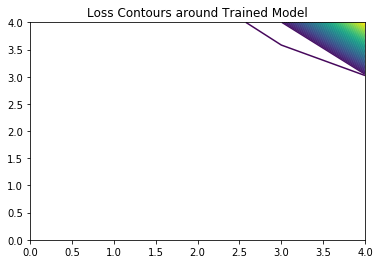

c:\users\marce\pycharmprojects\loss-landscapes\env\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


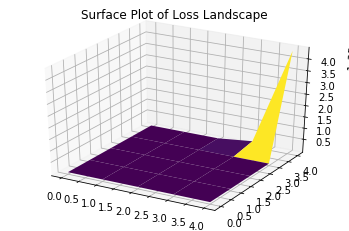

In [8]:
# plot
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

## 4. Training With Batch Normalization

In [ ]:
# define model
model = MLPBatchNorm(IN_DIM, OUT_DIM)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

# stores the initial point, trains, and stores final point
model_initial = loss_landscapes.utils.deepcopy_model(model, 'torch')
train(model, optimizer, criterion, train_loader, EPOCHS)
model_final = loss_landscapes.utils.deepcopy_model(model, 'torch')

In [ ]:
# data that the evaluator will use when evaluating loss
x, y = iter(train_loader).__next__()
loss_evaluator = evaluators.LossEvaluator(criterion, x, y)

# set into train mode and compute loss
model_final.train()
loss_data_fin = loss_landscapes.random_plane(model_final, loss_evaluator, 200, STEPS, 'layer')
model_final.eval();

In [ ]:
# plot
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

## 5. Tracking the Smoothness of the Optimization Trajectory